<a href="https://colab.research.google.com/github/AimanAminuddin/Image-Classifier/blob/main/Image%20Recontrusction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax 
from jax.config import config
config.update('jax_enable_x64', True)  # often needed for LBFGS that requires high-precision

import jax.numpy as jnp
import numpy as np
import pylab as plt

import imageio
import os
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy

Exercise: low rank factorization

---


Load the matrix  $𝐴∈ℝ^{𝑝,𝑞}$  with  $(𝑝,𝑞)=(1000,2000)$  contained in matrix_a_tut7.npy and find  $𝑈∈ℝ^{𝑝,𝑟}$  and  𝑉∈ℝ𝑟,𝑞  where  $𝑟=50$  such that  $𝐴\approx𝑈𝑉$ .

In [ ]:
path = r"/content/drive/MyDrive/DSA4212/"
A = np.load(os.path.join(path, "matrix_a_tut7.npy"), allow_pickle=True)

In [ ]:
A

array([[-14.65092829,   3.68099291,  -0.49663323, ...,  -6.97419271,
          8.328246  ,  -0.36185494],
       [  2.38899718,  -7.57495126,  -5.13151465, ...,  -1.9824057 ,
         -2.96596575, -11.02051458],
       [  6.22714336,   4.11276162,  11.46538755, ...,  -1.22489594,
        -13.24106574,  -4.79436057],
       ...,
       [ -3.87491174,   4.54583324,  11.52977467, ...,  -1.06745125,
        -16.84593327,   9.02972576],
       [ 13.06396873, -10.99990539,  15.7552079 , ...,  -7.39772034,
         -1.36834786, -14.20374419],
       [ -3.38260251,   0.25168814,  -0.57204502, ...,   1.71240301,
         -1.10598773,  -5.90484938]])

In [ ]:
A.shape 

(1000, 2000)

In [ ]:
m,n = A.shape 

In [ ]:
r = 10 

**Exercise: Matrix Completion**

---
In the previous exercise, suppose that only a few entries are observed and you would like to estimate the unobserved entries. Implement a latent factor approach for solving this problem.

In [ ]:
# let us generate the list of observed entries
#A = np.load("matrix_a_tut7.npy", allow_pickle=True)
p,q = A.shape

N_obs = 10000 #number of observed entries
u_list = np.random.choice(range(p), replace=True, size=N_obs)
f_list = np.random.choice(range(q), replace=True, size=N_obs)
ratings_list= A[u_list.astype(int), f_list.astype(int)]

In [ ]:
u_list

array([787, 732, 493, ..., 853, 868, 222])

In [ ]:
f_list 

array([ 309,  579,  651, ..., 1301, 1210, 1066])

In [ ]:
@jax.jit
def MSE(A,U,V):
  return jnp.mean(((A - U@V.T) **2)[u_list,f_list])

In [ ]:
U = np.random.normal(0,1,(m,r))
V = np.random.normal(0,1,(n,r))

In [ ]:
len(u_list) == len(f_list)

True

In [ ]:
MSE_grad_u = jax.jit(jax.grad(MSE,argnums = 1)) 
MSE_grad_v = jax.jit(jax.grad(MSE,argnums = 2))

In [ ]:
MSE(A,U,V)

DeviceArray(60.38562407, dtype=float64)

In [ ]:
MSE_grad_u(A,U,V)

DeviceArray([[-0.00188303,  0.00479345, -0.00057459, ..., -0.00095605,
              -0.00049962, -0.00036592],
             [ 0.0035672 ,  0.00111687, -0.00694158, ...,  0.0070237 ,
               0.00783512, -0.00371531],
             [ 0.00415565, -0.00043916, -0.00185055, ...,  0.0021011 ,
              -0.00091322,  0.00273279],
             ...,
             [ 0.00434584, -0.00034648,  0.003524  , ...,  0.00841126,
               0.00453391,  0.00189138],
             [-0.00077011, -0.00062091, -0.00710039, ...,  0.0022407 ,
               0.00066078,  0.01208254],
             [ 0.00794686,  0.00118466, -0.01141404, ..., -0.00963501,
               0.00045391, -0.00155943]], dtype=float64)

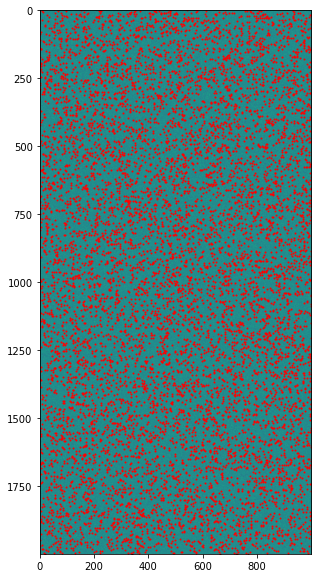

In [ ]:
# let us display the matrix A and the observed entries
plt.figure(figsize=(10,10))
plt.imshow(A.T)
plt.scatter(u_list, f_list, color="red", s=1)

In [ ]:

def faster_matrix_factorization(R,k,iterations = 1500,learning_rate = 5):
  loss_history = []
  m,n = R.shape 
  N = m*n 
  P = np.random.normal(0,1,size = (m,k))
  Q = np.random.normal(0,1,size = (n,k))


  for i in range(iterations): 
    grad_P = MSE_grad_u(A,P,Q)
    grad_Q = MSE_grad_v(A,P,Q)
    P -= learning_rate * grad_P 
    Q -= learning_rate * grad_Q 


    # calculate MSE 
    value = MSE(A,P,Q)
    
    loss_history.append(value)

    if i % 50 == 0: 
      print("MSE is " + str(value))
    

  return P,Q,loss_history

In [ ]:
U,V,loss_history = faster_matrix_factorization(A,10)

MSE is 56.983864403874804
MSE is 10.04825884823148
MSE is 2.1984929319239597
MSE is 0.6637011911710012
MSE is 0.2403668444272057
MSE is 0.09786253540698335
MSE is 0.04346459234481082
MSE is 0.020695192540431107
MSE is 0.01043359015467612
MSE is 0.005518341471278849
MSE is 0.0030413803429932104
MSE is 0.0017379676465287444
MSE is 0.0010256250302108857
MSE is 0.0006229250694695694
MSE is 0.0003882074054849136
MSE is 0.0002475500531361493
MSE is 0.00016110789160862812
MSE is 0.00010675746406785945
MSE is 7.187389072072512e-05
MSE is 4.9067162417762267e-05
MSE is 3.390808993127412e-05
MSE is 2.368321510534651e-05
MSE is 1.6696150851579543e-05
MSE is 1.186637555025115e-05
MSE is 8.49376709324837e-06
MSE is 6.117542643308382e-06
MSE is 4.430105878895932e-06
MSE is 3.2234667037479294e-06
MSE is 2.3553487458773748e-06
MSE is 1.7274090380186743e-06


Text(0, 0.5, 'MSE')

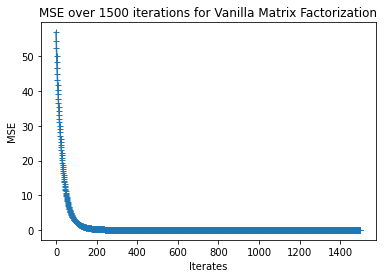

In [ ]:
plt.plot(loss_history,"-+")
plt.title("MSE over 1500 iterations for Vanilla Matrix Factorization")
plt.xlabel("Iterates")
plt.ylabel("MSE")

In [ ]:
# calculating MSE 
print("MSE is " + str(loss_history[-1])) 
print("RMSE is " + str(loss_history[-1]**0.5))

MSE is 1.2788194516643522e-06
RMSE is 0.0011308489959602707


**Non-Negative Matrix Factorization**

---
Let us try to implement a Nonnegative Matrix Factorization model on the face dataset of assignment 1 (celeba). To do so, we will select the first 5000 images and try to express each one of these faces as the superposition of  𝑅  positives atomes. In other words, we will try to find  𝑅  images  𝐴1,…,𝐴𝑅 , that we call atoms, such that each face  𝑋𝑖  can be approximately expressed as

$𝑋_{i}=𝑐_{i1}𝐴_{1}+𝑐_{i2}𝐴_{2}+\dots +𝑐_{iR}𝐴_{R}$
 
where each of the coeeficient  𝑐_{ij}  are also positive. In order to get rid of the positivity constraint and use LBFGS, we will use the function $\sigma(x) + \log(1+\exp(x))$ to transform a real number into a positive number.


In [ ]:
path_csv  = r"/content/drive/MyDrive/DSA4212/"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))

In [ ]:
# print out the different attributes of each image 
attribute.keys()

Index(['Filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
!unzip /content/drive/MyDrive/DSA4212/img_celeba_small.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_celeba_small/017501.jpg  
  inflating: __MACOSX/img_celeba_small/._017501.jpg  
  inflating: img_celeba_small/017502.jpg  
  inflating: __MACOSX/img_celeba_small/._017502.jpg  
  inflating: img_celeba_small/017503.jpg  
  inflating: __MACOSX/img_celeba_small/._017503.jpg  
  inflating: img_celeba_small/017504.jpg  
  inflating: __MACOSX/img_celeba_small/._017504.jpg  
  inflating: img_celeba_small/017505.jpg  
  inflating: __MACOSX/img_celeba_small/._017505.jpg  
  inflating: img_celeba_small/017506.jpg  
  inflating: __MACOSX/img_celeba_small/._017506.jpg  
  inflating: img_celeba_small/017507.jpg  
  inflating: __MACOSX/img_celeba_small/._017507.jpg  
  inflating: img_celeba_small/017508.jpg  
  inflating: __MACOSX/img_celeba_small/._017508.jpg  
  inflating: img_celeba_small/017509.jpg  
  inflating: __MACOSX/img_celeba_small/._017509.jpg  
  inflating: img_celeba_small/017510.jpg  
  inflating: __MACOSX/img_celeba_

In [ ]:
path = r"/content/img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


In [ ]:

print(all_img)

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.jpg', '000041.jpg', '000042.jpg', '000043.jpg', '000044.jpg', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '000071.jpg', '0000

In [ ]:
# load the first 5000 images, transform to grauscale by averaging the channels, and do a bit of cropping
im_list = []
for k in range(5000):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = np.mean(im, axis=2)
    #resize to 100x100 for display
    im = resize(im, (70,70) )
    im = im[15:55, 20:50] / 255.
    im_list.append(im)

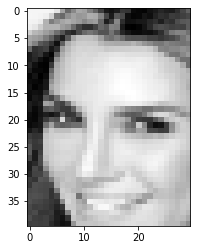

In [ ]:
#let us plot the first image just for sanity check
plt.imshow(im_list[0], cmap="gray")

In [ ]:
faces = np.array(im_list)        #make an array out of all these facse
N,dx,dy = faces.shape
p = dx*dy
faces_flat = faces.reshape(N,-1)  # flatten the images into lon vectors

In [ ]:
faces.shape 

(5000, 40, 30)

In [ ]:
U = np.random.normal(0,1,size = (m,r))

**Map all real numbers to a positive number**

In [ ]:
def make_positive(x):
    return jnp.log(1. + jnp.exp(x))

In [ ]:
# number of atoms
R = 100

# generate some random atoms and coefficients, just to find out the correct dimensions
atoms_ = np.random.normal(0,1, size=(R,dx*dy))
coefs_ = np.random.normal(0,1, size=(N,R))

# make them positives
atoms = make_positive(atoms_)
coefs = make_positive(coefs_)

# get the dimensions
atom_dimx, atom_dimy = atoms.shape
coefs_dimx, coefs_dimy = coefs.shape

# we will concatenate all these coefficients and atoms into a long vector and apply LBFGS on that
# this long vector if parameter will have dimension: atom_dimx*atom_dimy + coefs_dimx*coefs_dimy
param_dim = atom_dimx*atom_dimy + coefs_dimx*coefs_dimy

# generate a random initial parameter
param_init = np.random.normal(0,1,size=param_dim)

@jax.jit
def extract_atoms_and_coefs(param):
    """ helper function to extract the atoms and coefficients out of the long parameter vector """
    atoms = param[:(atom_dimx*atom_dimy)]
    coefs = param[(atom_dimx*atom_dimy):]
    return atoms, coefs

@jax.jit
def loss_NMF(param):
    # exatrct the log atoms and coefs
    atoms_, coefs_ = extract_atoms_and_coefs(param)
    
    # make it positive by applying the function log(1+exp(x))
    atoms = make_positive(atoms_).reshape(R,dx*dy)
    coefs = make_positive(coefs_).reshape(N,R)
    
    # compute the reconstructed faces
    faces_flat_reconstructed = coefs @ atoms
    
    # mean squared error between reconstructured and original image
    return jnp.mean( (faces_flat_reconstructed - faces_flat)**2 )
    

# automatic differentiation magic here!
loss_NMF_grad = jax.jit(jax.grad(loss_NMF))

#let's create a wrapper to make sure the output is a standard numpy gradient
def loss_NMF_grad_wrapper(param):
    return np.array(loss_NMF_grad(param))


In [ ]:
loss_history = []  #to save the loss trajectory
time_history = []  #to save the compute time
iteration_index = 0

def save_traj(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_NMF(param)

    # display the loss every 10 iterations
    if iteration_index % 10 == 0:
        print(f"iteration:{iteration_index} \t \t loss={current_loss:5.5}")
    
    # record everything
    loss_history.append(current_loss)
    time_history.append(time.time() - start)

start = time.time()
traj = scipy.optimize.minimize(fun = loss_NMF, #functino to minimize
                                x0 = param_init, #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=loss_NMF_grad_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                tol=10**-10,
                                options={"maxiter":100})  #maximum number of iteration

iteration:10 	 	 loss=1.9405
iteration:20 	 	 loss=0.028871
iteration:30 	 	 loss=0.023617
iteration:40 	 	 loss=0.016227
iteration:50 	 	 loss=0.012355
iteration:60 	 	 loss=0.010629
iteration:70 	 	 loss=0.0093153
iteration:80 	 	 loss=0.008218
iteration:90 	 	 loss=0.007512
iteration:100 	 	 loss=0.0069661


Text(0, 0.5, 'MSE reconstruction')

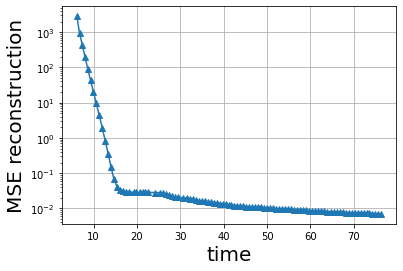

In [ ]:
plt.plot(time_history, loss_history, "-^")
plt.yscale("log")
plt.grid(True)
plt.xlabel("time", fontsize=20)
plt.ylabel("MSE reconstruction", fontsize=20)

In [ ]:
#extrct final parameter found by LBFGS
final_param =traj["x"]
atoms_, coefs_ = extract_atoms_and_coefs(final_param)

# make it positive by applying the function log(1+exp(x))
atoms = make_positive(atoms_).reshape(R,dx*dy)
coefs = make_positive(coefs_).reshape(N,R)

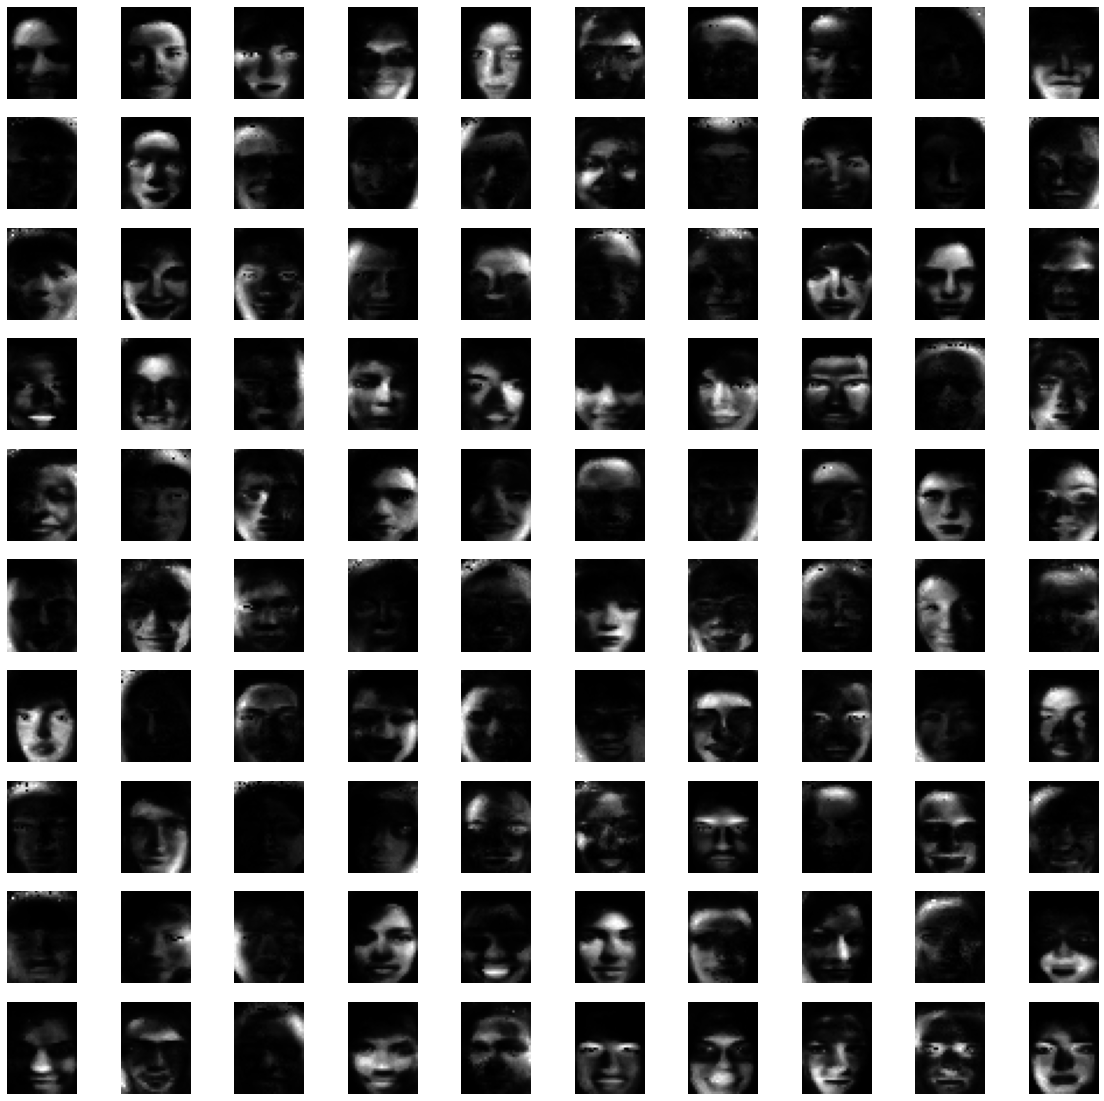

In [ ]:
# plot the atoms found
plt.figure(figsize=(20,20))
for k in range(10*10):
    plt.subplot(10,10,k+1)
    plt.imshow(atoms[k,:].reshape(dx,dy), cmap="gray")
    plt.axis(False)

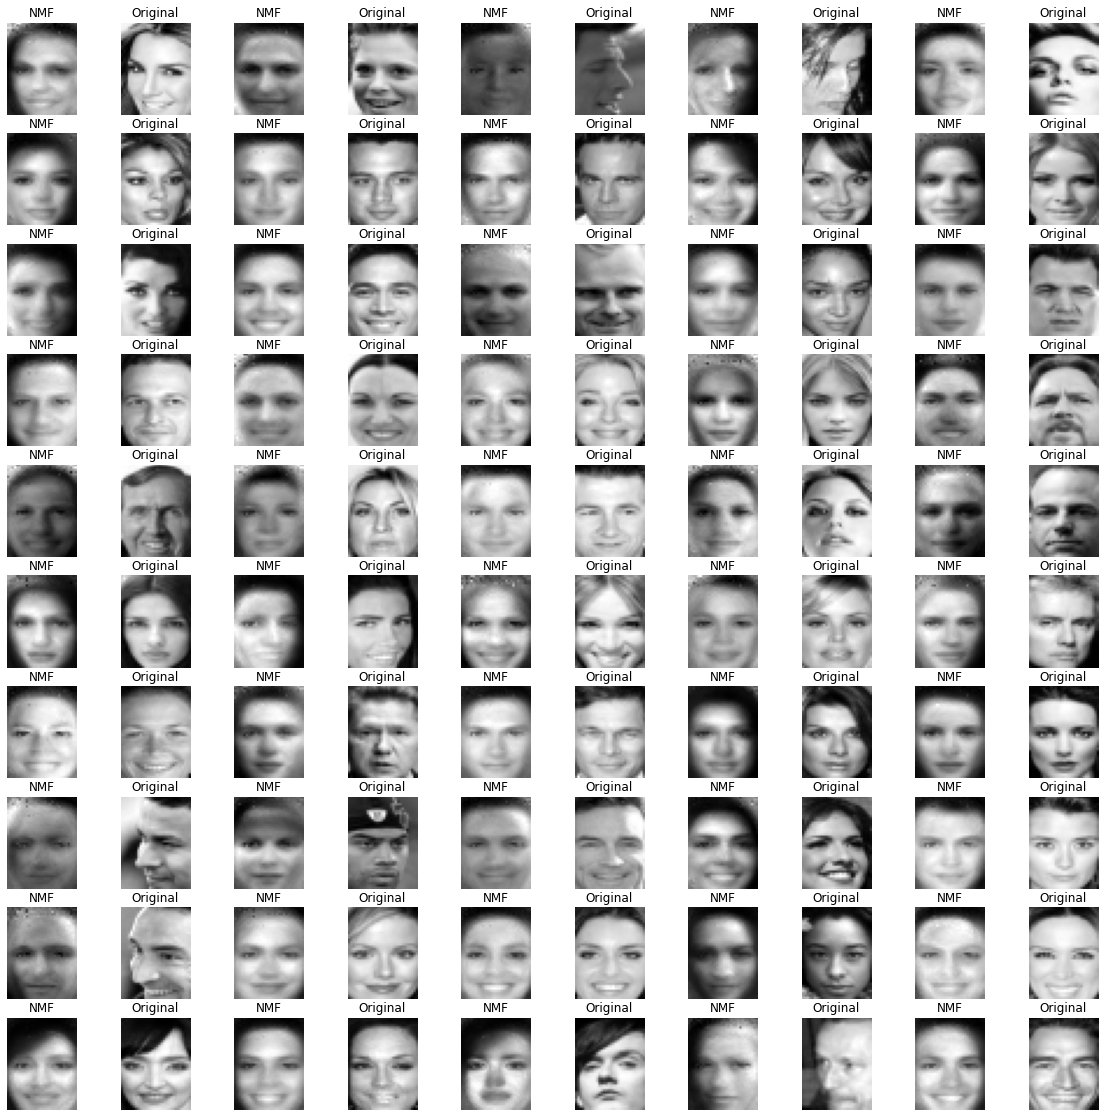

In [ ]:
# compute reconstructed faces
faces_flat_reconstructed = coefs @ atoms
faces_reconstructed = faces_flat_reconstructed.reshape(N, dx, dy)

# display the first few original and reconstructed faces
plt.figure(figsize=(20,20))
for k in range(5*10):
    plt.subplot(10,10,2*k+1)
    plt.imshow(faces_reconstructed[k,:,:], cmap="gray")
    plt.title("NMF")
    plt.axis(False)

    plt.subplot(10,10,2*k+2)
    plt.imshow(faces[k,:,:], cmap="gray")
    plt.title("Original")
    plt.axis(False)